<a href="https://colab.research.google.com/github/karasu1982/POS_Data_Analytics/blob/main/notebook/%E3%83%AA%E3%83%94%E3%83%BC%E3%83%88%E7%8E%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リピート率

リピート率は、特定の期間内に同じ人に複数回購入される確率と定義され、「商品の2回以上購入者数÷商品の総購入者数」で計算されます。

ABC分析とセットでみることで、ABC分析でCランクでも、リピート率が高い商品は「ファンが存在」するために、棚落ちをさせないといった判断をすることができます。

「同じ人」と判断するために、「人」を把握できないPOSデータでは分析できず、ID-POSデータ特有の分析といえます。

## 環境設定

In [ ]:
%%bash
pip install duckdb-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.2 MB/s eta 0:00:00


In [ ]:
# 標準ライブラリ
import pandas as pd
import numpy as np

# データ見える化
import seaborn as sns
import matplotlib.pyplot as plt

# DuckDB
import duckdb

## データ準備

ID-POSのサンプルデータとして、下記を利用

https://www.kyoritsu-pub.co.jp/book/b10003634.html

In [ ]:
%%bash
wget https://kyoritsu-pub.sakura.ne.jp/app/file/goods_contents/2319.zip
unzip /content/2319.zip
unzip /content/DataProcess.20151001/src/data/Tafeng/Tafeng.zip

In [ ]:
df = pd.read_csv("/content/Tafeng_dataset/Tafeng.csv")

# データ型を
df = df.astype({'CustID': 'object', 'ProductSubClass': 'object', 'ProductID': 'object'})

In [ ]:
df.head(3)

,Time,CustID,Age,Area,ProductSubClass,ProductID,Amount,Asset,SalesPrice
0,2000-11-01 00:00:00,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01 00:00:00,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01 00:00:00,663373,F,E,110217,4710265847666,1,180,135


## データ集計

1点注意として、商品の種類によって集計期間を定める必要があります。

例えば、シャンプーのような商品であれば、3ヶ月程度の期間で買い替えるため、集計期間をそれ以下にしてしまうと、2回以上購入者がほとんど存在しないという正しくない結果になってしまいます。

その商品カテゴリの購入間隔に合わせた、適切な集計期間を定めていきましょう。

※下記例では、商品の種類がわからないため、期間を定めずに全期間で出しています。

In [ ]:
import duckdb

# SQLに慣れている方にとっては、少々くどいかもしれませんが、可読性を高めるために、処理を１つ１つ分解してWITH句で実行しています。
#
# 私がBigQueryの文法に慣れていることもあり、次の3点で修正が必要でした。他にも微妙な差はありそうなので、都度都度直す必要がありますね。
# ・コメントアウトは#は使わず、-- で行う
# ・文字列はダブルコーテーション（ " )ではなく、シングルクオーテーション（ ' )でくくる
# ・日付項目は、文字列を自動で日付型化しないため、DATETIME '2000-11-01'のように日付型を明示的に指定する
#

df_output = duckdb.query(
    f"""
    WITH
    t_purchaser AS(
      -- 商品ごとの購入者
      SELECT
        ProductID,
        COUNT(DISTINCT CustID) AS Num_of_Purchaser
      FROM df
      GROUP BY ProductID
    ),

    t_repeat AS(
      -- 商品コードごとの複数回購入者
      SELECT
        ProductID,
        COUNT(DISTINCT CustID) AS Num_of_Repeater
      FROM (SELECT CustID, ProductID, COUNT(*) AS Num_of_Purchase FROM df GROUP BY CustID, ProductID HAVING Num_of_Purchase >= 2)
      GROUP BY ProductID
    )

    SELECT
      ProductID,
      Num_of_Purchaser,
      Num_of_Repeater,
      Num_of_Repeater / Num_of_Purchaser AS Percentage_of_Repeat
    FROM t_purchaser
    LEFT OUTER JOIN t_repeat
    USING(ProductID)

    ORDER BY Num_of_Purchaser desc
    """
).to_df()

作成したテーブルのアウトプット
*   ProductID：商品コード。元々あって今回集計キーにした項目
*   Num_of_Purchaser：商品の総購入者数
*   Num_of_Repeater：商品の2回以上購入者数
*   Percentage_of_Repeat：リピート率＝商品の2回以上購入者数÷商品の総購入者数

購入者数が多い順にソートします。すると、購入者がトップの商品は、リピート率も0.265(26.5%)と高くなっています

In [ ]:
 # データ確認
df_output.head(100)

,ProductID,Num_of_Purchaser,Num_of_Repeater,Percentage_of_Repeat
0,4714981010038,6026,1598.0,0.265184
1,4711271000014,5236,747.0,0.142666
2,4719090900065,2087,273.0,0.130810
3,4710265849066,1775,205.0,0.115493
4,4710114128038,1734,312.0,0.179931
...,...,...,...,...
95,4710174053691,595,15.0,0.025210
96,4710321790509,595,59.0,0.099160
97,4710871000165,594,54.0,0.090909
98,4710094004711,593,51.0,0.086003


リピート率が高い順にソートすると、上位にはリピート率が100％の商品が並んでいます

しかし、総購入者も1人しか存在しない商品が並んでおり、「偶然その商品を買った人が、2回買っただけ」のようなケースが見られます

In [ ]:
# リピート率が高い商品にソート
df_output.sort_values("Percentage_of_Repeat", ascending=False)

,ProductID,Num_of_Purchaser,Num_of_Repeater,Percentage_of_Repeat
23811,20423650,1,1.0,1.0
22046,4719535001036,1,1.0,1.0
22433,4711629850025,1,1.0,1.0
22432,4718079820479,1,1.0,1.0
22431,4901616006553,1,1.0,1.0
...,...,...,...,...
23791,65300010920,1,NaN,NaN
23792,2100230001544,1,NaN,NaN
23793,20506155,1,NaN,NaN
23794,4712297139047,1,NaN,NaN


そのような事態を避けるため、総購入者数が一定（ここでは100人）以上の商品に絞って、リピート率が高い順に出すことが１つのアイデアとして挙げられます。

すると、購入者数トップの商品よりも、リピート率が高く、33.0%の商品があることがわかる。

In [ ]:
# 総購入者数が100人以上の商品に絞って、リピート率が高い順にソート
df_output[df_output["Num_of_Purchaser"]>=100].sort_values("Percentage_of_Repeat", ascending=False)

,ProductID,Num_of_Purchaser,Num_of_Repeater,Percentage_of_Repeat
665,4710628131012,194,64.0,0.329897
0,4714981010038,6026,1598.0,0.265184
1383,4901301011732,114,29.0,0.254386
1163,4710628119010,129,32.0,0.248062
1576,9310022724206,102,25.0,0.245098
...,...,...,...,...
1413,4712815116284,111,NaN,NaN
1451,4711437000162,109,NaN,NaN
1514,2250078000039,105,NaN,NaN
1528,4710644160324,105,NaN,NaN


<Axes: xlabel='Num_of_Purchaser', ylabel='Percentage_of_Repeat'>

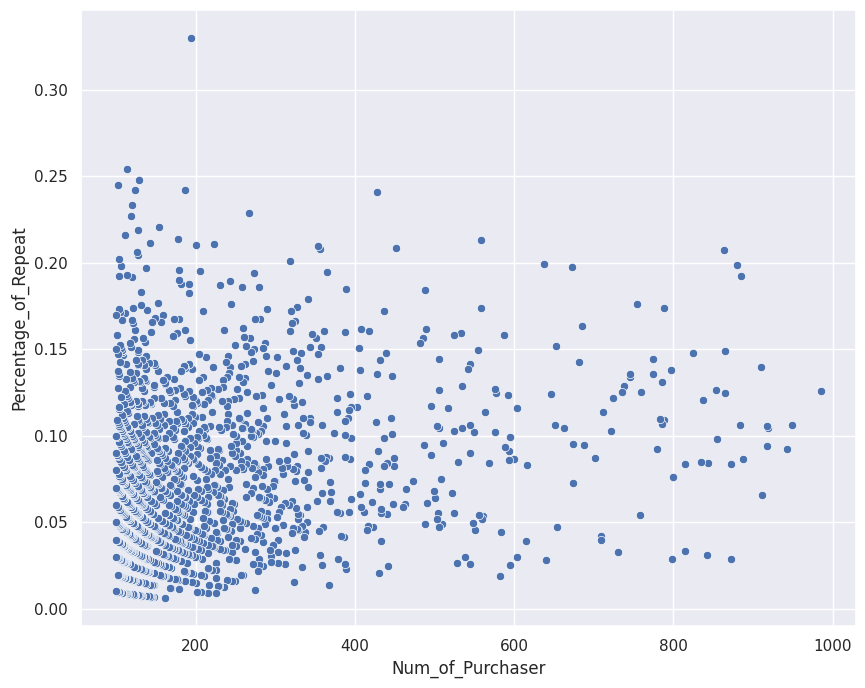

In [ ]:
# X軸：総購入者数とY軸：リピート率の散布図
# 総購入者が100〜1000人の間の商品

plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.scatterplot(data=df_output[(df_output["Num_of_Purchaser"]>=100)&(df_output["Num_of_Purchaser"]<=1000)],x="Num_of_Purchaser",y="Percentage_of_Repeat")

総購入者とリピート率で散布図を作成することで、４つの象限に分けてみることができます

*   右上：総購入者・リピート率ともに高い、主流商品
*   右下：総購入者は高く・リピート率が低い、お試しで買われた・安かったから買われた商品
*   左上：総購入者は低く・リピート率が高い、コアなファンが付いている商品
*   左下：総購入者・リピート率ともに低い、入れ替え検討商品

